In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

img_height = 180
img_width = 180
batch_size = 20
data_dir = "Data"

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "Data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67 files belonging to 4 classes.
Using 54 files for training.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "Data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67 files belonging to 4 classes.
Using 13 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['bbpooh', 'bbroo', 'bbtig', 'lola']


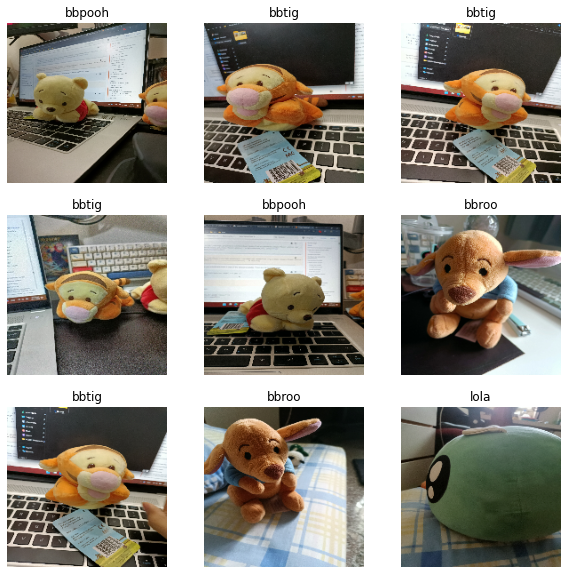

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 180, 180, 3)
(20,)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

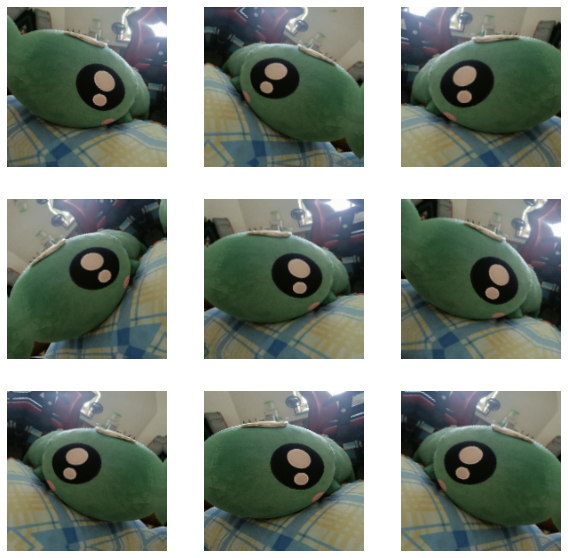

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [15]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 1s 381ms/step - loss: 2.0098 - accuracy: 0.4630 - val_loss: 2.1109 - val_accuracy: 0.4615
Epoch 2/15
3/3 [==============================] - 0s 152ms/step - loss: 1.2264 - accuracy: 0.4074 - val_loss: 1.1267 - val_accuracy: 0.3846
Epoch 3/15
3/3 [==============================] - 0s 159ms/step - loss: 0.8153 - accuracy: 0.6667 - val_loss: 1.1914 - val_accuracy: 0.4615
Epoch 4/15
3/3 [==============================] - 0s 179ms/step - loss: 0.5527 - accuracy: 0.7963 - val_loss: 0.8675 - val_accuracy: 0.5385
Epoch 5/15
3/3 [==============================] - 0s 163ms/step - loss: 0.3099 - accuracy: 0.9074 - val_loss: 0.7354 - val_accuracy: 0.6923
Epoch 6/15
3/3 [==============================] - 0s 147ms/step - loss: 0.1606 - accuracy: 0.9630 - val_loss: 0.5757 - val_accuracy: 0.8462
Epoch 7/15
3/3 [==============================] - 0s 155ms/step - loss: 0.0450 - accuracy: 1.0000 - val_loss: 0.2270 - val_accuracy: 0.9231
Epoch 8/15
3/3 [====

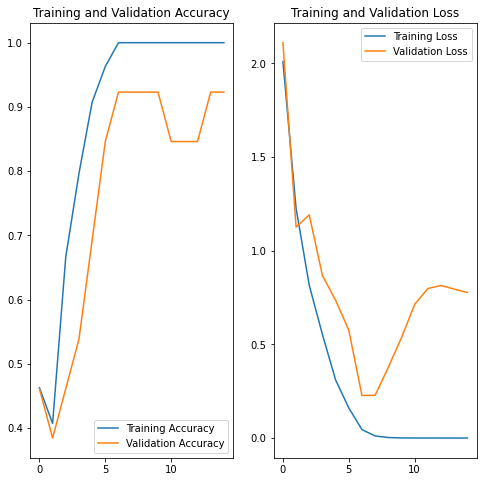

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
img = tf.keras.utils.load_img(
    "D:\OneDrive - Nanyang Technological University\Year 2 Sem 2\SC2079 MDP\Tensor_Testing\Validation Data\IMG20230121111502.jpg",
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to bbtig with a 100.00 percent confidence.


In [18]:
tf.keras.Model.save(model, "D:\OneDrive - Nanyang Technological University\Year 2 Sem 2\SC2079 MDP\Tensor_Testing\Keras_Model")

INFO:tensorflow:Assets written to: D:\OneDrive - Nanyang Technological University\Year 2 Sem 2\SC2079 MDP\Tensor_Testing\Keras_Model\assets


In [19]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("D:\OneDrive - Nanyang Technological University\Year 2 Sem 2\SC2079 MDP\Tensor_Testing\Keras_Model") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [20]:
interpreter = tf.lite.Interpreter(model_path="D:\OneDrive - Nanyang Technological University\Year 2 Sem 2\SC2079 MDP\Tensor_Testing\model.tflite")

In [21]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['rescaling_1_input'], 'outputs': ['dense_1']}}

In [22]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [23]:
predictions_lite = classify_lite(rescaling_1_input=img_array)['dense_1']
score_lite = tf.nn.softmax(predictions_lite)

In [24]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to bbtig with a 100.00 percent confidence.
